# Lego classification using CNN

In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Open the files:
train_fh = open('/Users/skyrex/Desktop/my/учеба/прога/neural networks course spbu/lego pieces classification/lego-train.pickle', 'rb')
test_fh = open('/Users/skyrex/Desktop/my/учеба/прога/neural networks course spbu/lego pieces classification/lego-test.pickle', 'rb')

# Use pickle to load files into runtime objects:
train_dataloader = pickle.load(train_fh)
test_dataloader = pickle.load(test_fh)

# train_data -> [] of tuples: (ndarray, uint8 label) 

In [3]:
# For humans:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', 
               '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth',
               '1x2 Handles', '1x2 Grill']


In [4]:
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [5]:
class LegoDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
import torchvision.transforms as transforms

tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128, antialias=True),
    transforms.Normalize(0.13, 0.31)
])

train_dataset = LegoDataset(train_dataloader, tfs)
test_dataset = LegoDataset(test_dataloader, tfs)

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
def label2text(label):
    if not isinstance(label, int):
        label = label.item()
        
    return class_names[label]

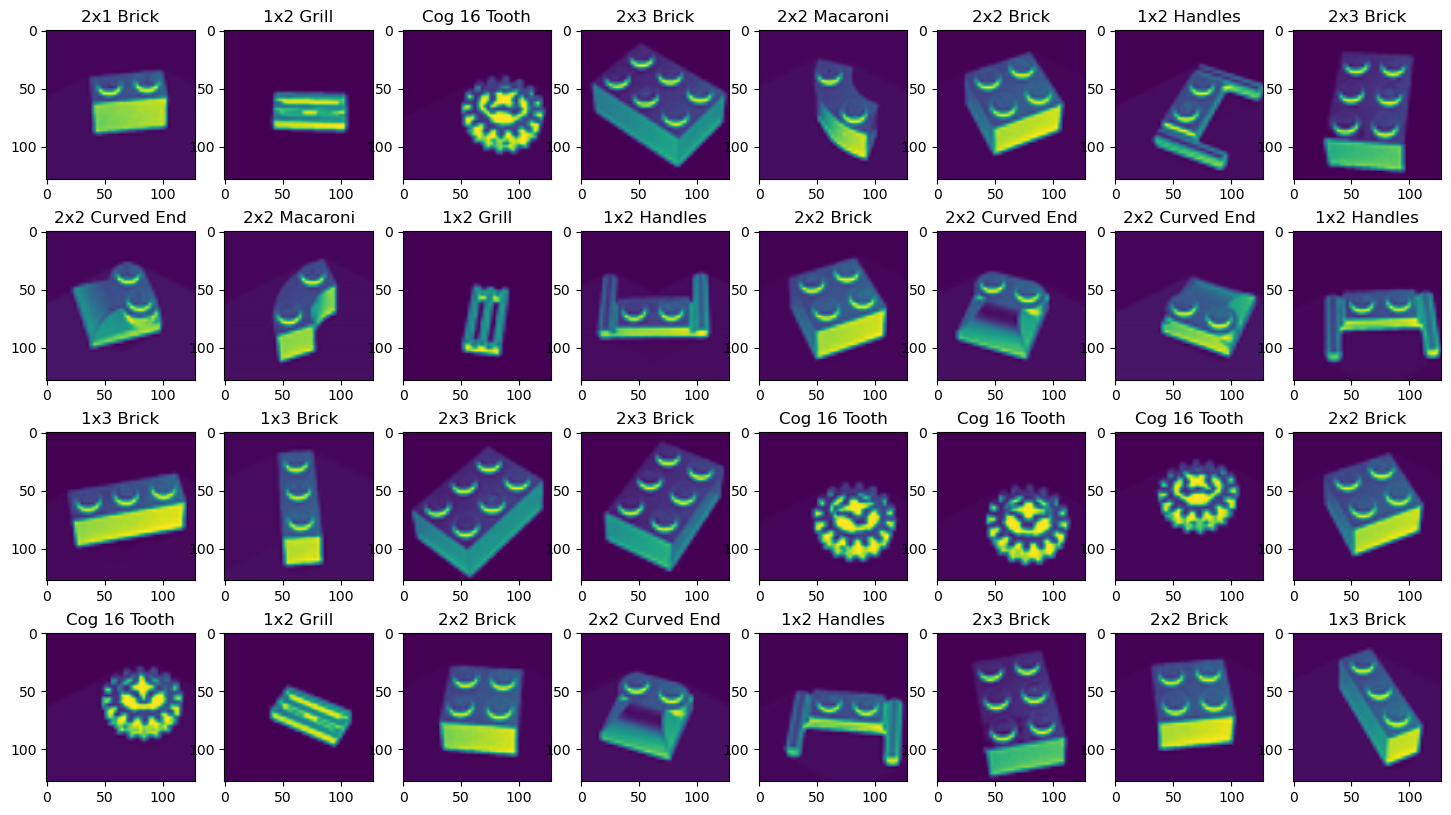

In [9]:
X, y = next(iter(train_dataloader))

rows, cols = 4, 8
fig, axs = plt.subplots(rows, cols, figsize=(18, 10))

for i in range(rows * cols):
    r, c = i // cols, i % cols
    axs[r, c].imshow(np.transpose(X[i].detach().numpy(), (1, 2, 0)))
    axs[r, c].title.set_text(label2text(y[i]))



## CNN implementation

In [10]:
import torch
from torch import nn

### Building model

In [11]:
class MyCNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.linear = nn.Sequential(
            nn.Linear(in_features=29*29*16, out_features=5000),
            nn.BatchNorm1d(num_features=5000),
            nn.ReLU(),
            nn.Linear(in_features=5000, out_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=10),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)

        x = x.reshape(-1, 16*29*29)

        return self.linear(x)

### Training model

In [14]:
from tqdm import tqdm
# from torch.utils.tensorboard import SummaryWriter

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [15]:
def train(model, optim, criterion, train_dataloader, test_dataloader, num_epochs=10):
    losses = {'train': [], 'test': []}
    train_n_iter = 0
    test_n_iter = 0
    
    # writer = SummaryWriter()
    for epoch in tqdm(range(num_epochs), desc="Epoch"):

        model.train()
        train_loss = 0

        for X_batch, y_batch in train_dataloader:
            optim.zero_grad()
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            loss.backward()
            optim.step()
            train_loss += loss.item()
            # writer.add_scalar('Loss/train', loss.item(), train_n_iter)
            train_n_iter += 1
                
        losses['train'].append(train_loss / len(train_dataloader))

        model.eval()
        test_loss = 0
        for X_batch, y_batch in test_dataloader:
            with torch.no_grad():
                y_pred = model(X_batch.to(device))
                
            loss = criterion(y_pred, y_batch.to(device))
            test_loss += loss.item()
            # writer.add_scalar('Loss/test', loss.item(), test_n_iter)
            test_n_iter += 1
        
        losses['test'].append(test_loss / len(test_dataloader))

        print(f'Epoch: {epoch + 1}/{num_epochs}; train_loss: {train_loss}; test_loss: {test_loss}')
        
    plt.plot(losses['train'], label='train loss')
    plt.plot(losses['test'], label='test loss')
    plt.legend()
    
    return losses

                    

In [16]:
model = MyCNN().to(device)

optim = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Epoch:  10%|███▋                                 | 1/10 [00:08<01:13,  8.17s/it]

Epoch: 1/10; train_loss: 15.090499948710203; test_loss: 23.083494663238525


Epoch:  20%|███████▍                             | 2/10 [00:15<01:03,  7.94s/it]

Epoch: 2/10; train_loss: 2.869721045717597; test_loss: 4.240893185138702


Epoch:  30%|███████████                          | 3/10 [00:23<00:55,  7.91s/it]

Epoch: 3/10; train_loss: 2.8532132701948285; test_loss: 1.357765182852745


Epoch:  40%|██████████████▊                      | 4/10 [00:31<00:46,  7.78s/it]

Epoch: 4/10; train_loss: 2.086420453619212; test_loss: 0.5149672422558069


Epoch:  50%|██████████████████▌                  | 5/10 [00:39<00:38,  7.74s/it]

Epoch: 5/10; train_loss: 1.7006383097032085; test_loss: 0.05598479078616947


Epoch:  60%|██████████████████████▏              | 6/10 [00:46<00:30,  7.67s/it]

Epoch: 6/10; train_loss: 1.8631977420300245; test_loss: 1.4211493507027626


Epoch:  70%|█████████████████████████▉           | 7/10 [00:54<00:22,  7.66s/it]

Epoch: 7/10; train_loss: 3.0336033360799775; test_loss: 0.05887198564596474


Epoch:  80%|█████████████████████████████▌       | 8/10 [01:01<00:14,  7.49s/it]

Epoch: 8/10; train_loss: 1.934999255812727; test_loss: 0.05157099277857924


Epoch:  90%|█████████████████████████████████▎   | 9/10 [01:08<00:07,  7.42s/it]

Epoch: 9/10; train_loss: 12.94481143032317; test_loss: 0.8563827127218246


Epoch: 100%|████████████████████████████████████| 10/10 [01:16<00:00,  7.60s/it]

Epoch: 10/10; train_loss: 5.782640134100802; test_loss: 0.04151960421586409


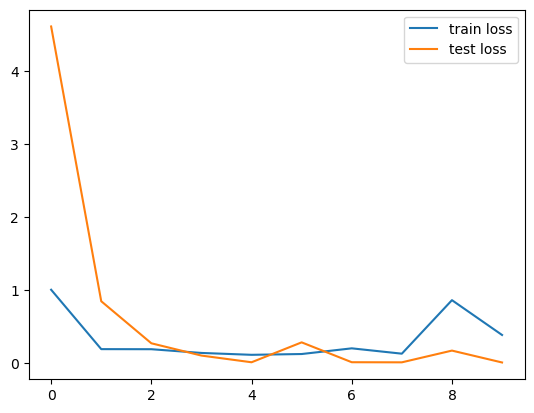

In [17]:
losses = train(model, optim, criterion, train_dataloader, test_dataloader, num_epochs=10)

###  Evaluate results

In [18]:
import itertools
from sklearn.metrics import accuracy_score

In [19]:
def accuracy(model, test_dataloader):
    model.eval()
    s = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch.to(device)).cpu().detach().numpy()
            y_pred = np.argmax(y_pred, axis=1)
            s += accuracy_score(y_batch.numpy(), y_pred)
            
    s /= len(test_dataloader)
    
    return s

In [20]:
print("Test accuracy:", accuracy(model, test_dataloader))

Test accuracy: 1.0


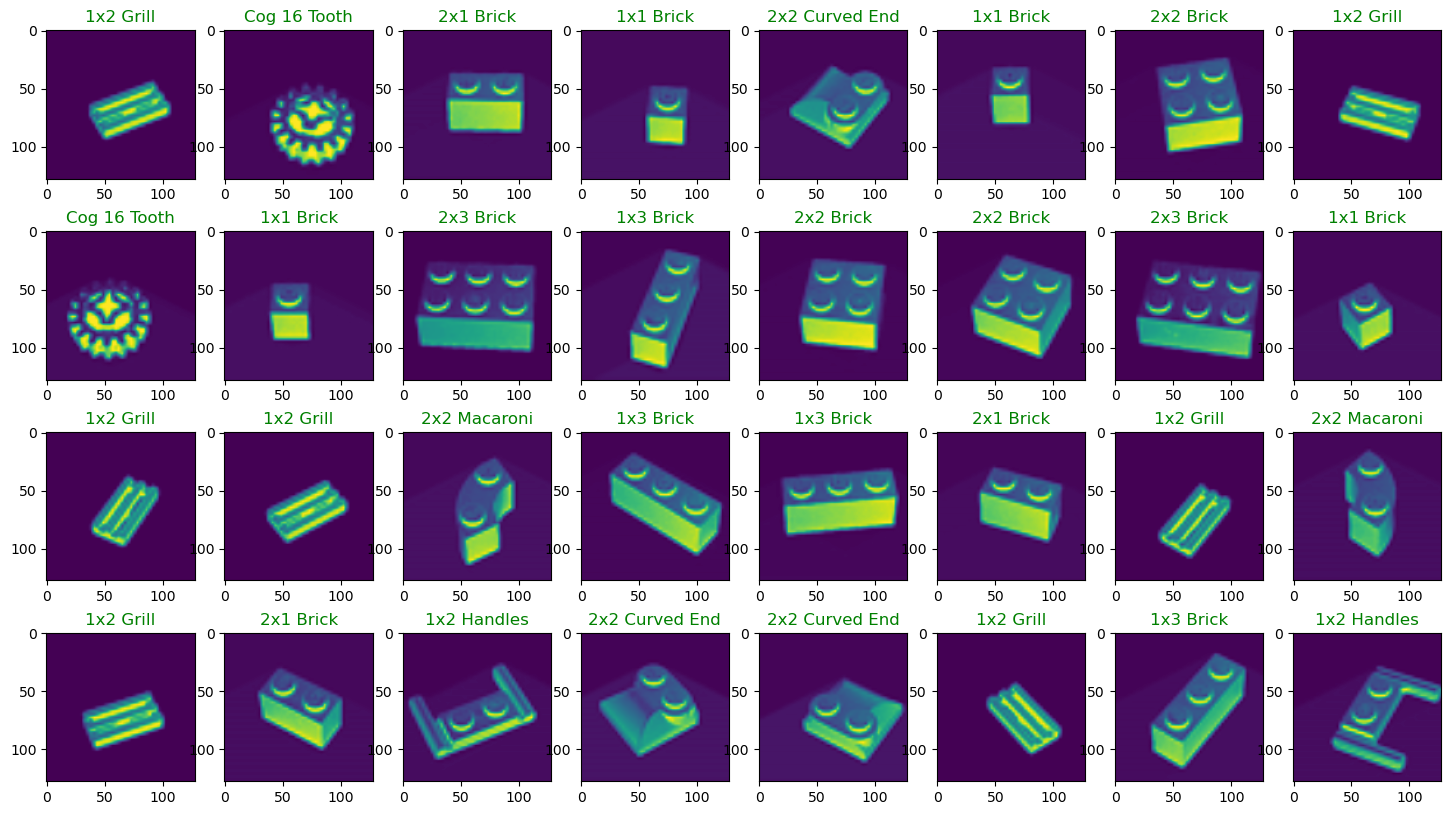

In [27]:
X, labels = next(iter(test_dataloader))

softmax = nn.Softmax(dim=1)
model.eval()

with torch.no_grad():
    y = softmax(model(X.to(device))).cpu().detach().numpy()
    X = X.cpu().detach().numpy()

rows, cols = 4, 8
fig, axs = plt.subplots(rows, cols, figsize=(18, 10))

k = 0
for i in range(rows * cols):
    r, c = i // cols, i % cols
    axs[r, c].imshow(np.transpose(X[i], (1, 2, 0)))
    txt = label2text(np.argmax(y[i]))
    original_label = class_names[labels[k].item()]
    if txt == original_label:
        axs[r, c].title.set_text(txt)
        axs[r, c].title.set_color('green')
    else:
        axs[r, c].title.set_text(txt)
        axs[r, c].title.set_color('red')
    k += 1